In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
%matplotlib inline 

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores
spark = SparkSession.builder \
    .master('local') \
    .appName('Spark Try') \
    .getOrCreate()

In [3]:
#interactive nodes

# # start spark master program on this machine and register worker nodes
# os.system('start-spark-slurm.sh&') # use & to put it into background

# # get ip address of this machine
# ip = os.popen('hostname -i').read().strip('\n')
# print 'Spark Master web UI: http://{}:8080'.format(ip)
   
# # get ip address of master node (current machine)
# ip = os.popen('hostname -i').read().strip('\n')

# # change 'local' to be ip of master node
# spark = SparkSession.builder \
#     .master('spark://' + ip + ':7077') \
#     .appName('Spark Try') \
#     .getOrCreate()
# print 'Spark Session web UI: http://{}:4040'.format(ip)

In [4]:
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

In [5]:
df.show()

+--------------------+--------------------+----+
|           president|                text|year|
+--------------------+--------------------+----+
|        James Monroe| Fellow-Citizens ...|1821|
|    William McKinley| To the Senate an...|1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|
|     Calvin Coolidge|Since the close o...|1923|
|       James Madison| Fellow-Citizens ...|1816|
|    Grover Cleveland| To the Congress ...|1886|
|   John Quincy Adams| Fellow Citizens ...|1827|
|  Theodore Roosevelt| To the Senate an...|1905|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|
|       James K. Polk| Fellow-Citizens ...|1848|
|      Woodrow Wilson|Gentlemen of the ...|1913|
|Dwight D. Eisenhower|[Delivered in per...|1955|
|         George Bush|Mr. President and...|1991|
|     Franklin Pierce| Fellow-Citizens ...|1856|
...|1944|
|   Lyndon B. Johnson|[Delivered in per...|1968|
|      Andrew Johnson| Fellow-Citizens ...|1867|
|      Woodrow Wilson|GENTLEMEN OF THE ...|1914|
|      Har

# (a) Parse texts into sentences

In [6]:
#df = df.withColumn("Sentences", df.rdd.map(lambda x: re.split('\. [A-Z]', x['text'])).collect())
df.rdd.map(lambda x: x['text']).collect()[0]

u' Fellow-Citizens of the Senate and House of Representatives:\r\n\r\n \r\n\r\nThe progress of our affairs since the last session has been such as may justly be claimed and expected under a Government deriving all its powers from an enlightened people, and under laws formed by their representatives, on great consideration, for the sole purpose of promoting the welfare and happiness of their constituents. In the execution of those laws and of the powers vested by the Constitution in the Executive, unremitted attention has been paid to the great objects to which they extend.\r\n\r\nIn the concerns which are exclusively internal there is good cause to be satisfied with the result. The laws have had their due operation and effect.\r\n\r\nIn those relating to foreign powers, I am happy to state that peace and amity are preserved with all by a strict observance on both sides of the rights of each.\r\n\r\nIn matters touching our commercial intercourse, where a difference of opinion has existe

In [7]:
@udf
def split_sent(s):
    return re.split('\. [A-Z]', s)

@udf
def split_word(s):
    return re.split(' ', s)

def div_(a,b):
    return a/b

count = udf(lambda s: len(s), IntegerType())
int_y = udf(lambda s: int(s), IntegerType())
div = udf(div_, FloatType())



In [10]:
df_a = df.withColumn("Sentences", split_sent(df.text))
df_a.show()

+--------------------+--------------------+----+--------------------+
|           president|                text|year|           Sentences|
+--------------------+--------------------+----+--------------------+
|        James Monroe| Fellow-Citizens ...|1821|[ Fellow-Citizens...|
|    William McKinley| To the Senate an...|1897|[ To the Senate a...|
|Dwight D. Eisenhower|[Delivered in per...|1960|[[Delivered in pe...|
|     Calvin Coolidge|Since the close o...|1923|[Since the close ...|
|       James Madison| Fellow-Citizens ...|1816|[ Fellow-Citizens...|
|    Grover Cleveland| To the Congress ...|1886|[ To the Congress...|
|   John Quincy Adams| Fellow Citizens ...|1827|[ Fellow Citizens...|
|  Theodore Roosevelt| To the Senate an...|1905|[ To the Senate a...|
|   Lyndon B. Johnson|Mr. Speaker, Mr. ...|1965|[Mr, peaker, Mr, ...|
|       James K. Polk| Fellow-Citizens ...|1848|[ Fellow-Citizens...|
|      Woodrow Wilson|Gentlemen of the ...|1913|[Gentlemen of the...|
|Dwight D. Eisenhowe

# (b)number of sentences, mean sentence lengths
For each year, compute the number of sentences in the address, and the mean sen- tence length in words for that year. Plot these data and two linear regressions, one plot for the number of sentences by year, another for the average sentence length by year. Note that the definition of “word” and “sentence” is imprecise. You can experi- ment with different parsing rules, and see if the results change qualitatively. Describe the trends that you see, and give some explanation for them.

In [11]:
df_b = df_a.withColumn("Sent_num", count(df_a.Sentences))
df_b = df_b.withColumn("Words", split_word(df_b.text))
df_b = df_b.withColumn("Word_num", count(df_b.Words))
df_b = df_b.withColumn("num_word_sent", div(df_b.Word_num, df_b.Sent_num))
df_b = df_b.withColumn("Year", int_y(df_b.year))
DF_b = df_b.groupBy('Year').mean('Sent_num', "num_word_sent").sort("Year")

In [21]:
DF_b.insert(1, 'Ones', 1)
#DF_b[:10]

,Year,Ones,avg(Sent_num),avg(num_word_sent)
0,1790,1,26.0,53.576923
1,1791,1,24.0,95.166664
2,1792,1,32.0,64.812500
3,1793,1,35.0,55.714287
4,1794,1,52.0,55.653847
5,1795,1,30.0,65.666664
6,1796,1,45.0,63.133335
7,1797,1,39.0,52.666668
8,1798,1,35.0,62.857143
9,1799,1,25.0,60.000000


In [72]:
#Linear regression for number of sentences by year
X = np.matrix(DF_b.iloc[:, (1, 0)].values)
y = np.matrix(DF_b.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

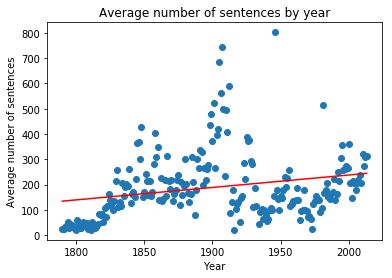

In [77]:
plt.scatter(DF_b['Year'], DF_b['avg(Sent_num)'])
plt.plot(DF_b['Year'], y_hat, color ='r')
#plt.legend()
plt.title("Average number of sentences by year")
plt.xlabel("Year")
plt.ylabel("Average number of sentences")

In [79]:
#Linear regression for average sentence length by year
X = np.matrix(DF_b.iloc[:, (1, 0)].values)
y = np.matrix(DF_b.iloc[:,3].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

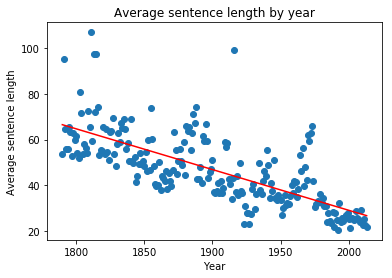

In [80]:
plt.scatter(DF_b['Year'], DF_b['avg(num_word_sent)'])
plt.plot(DF_b['Year'], y_hat, 'r')
plt.title("Average sentence length by year")
plt.xlabel("Year")
plt.ylabel("Average sentence length")

# (c)
Now, compute two regressions of the total number of words in a SOU versus year–one for the years 1790 to 1912, another for the years 1913 to the present. What trends do you see? Lookup the history of the State of the Union addresses (for example on Wikipedia) to explain the regressions.

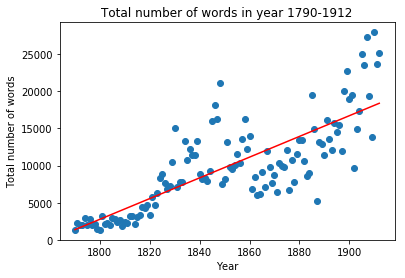

In [85]:
#Regression form year 1790 to 1912
DF_c1 = df_b.groupBy('Year').mean('Word_num').sort("Year").toPandas().iloc[:(1912-1790+1),:]
DF_c1.insert(1, 'Ones', 1)
#Linear regression for total number of words by year
X = np.matrix(DF_c1.iloc[:, (1, 0)].values)
y = np.matrix(DF_c1.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
#B = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose())
y_hat = np.dot(X, B)

plt.scatter(DF_c1['Year'], DF_c1.iloc[:,2])
plt.plot(DF_c1['Year'], y_hat, 'r')
plt.title("Total number of words in year 1790-1912")
plt.xlabel("Year")
plt.ylabel("Total number of words")

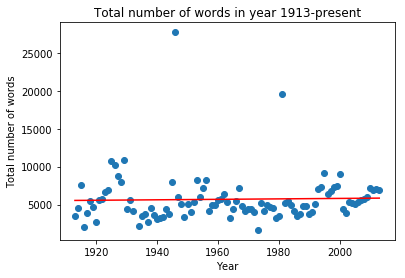

In [86]:
#Regression form year 1913 to present
DF_c2 = df_b.groupBy('Year').mean('Word_num').sort("Year").toPandas().iloc[(1912-1790+1):,:]
DF_c2.insert(1, 'Ones', 1)

#Linear regression for total number of words by year
X = np.matrix(DF_c2.iloc[:, (1, 0)].values)
y = np.matrix(DF_c2.iloc[:,2].values).transpose()
B = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),y)
y_hat = np.dot(X, B)

plt.scatter(DF_c2['Year'], DF_c2.iloc[:,2])
plt.plot(DF_c2['Year'], y_hat, 'r')
plt.title("Total number of words in year 1913-present")
plt.xlabel("Year")
plt.ylabel("Total number of words")

# (d)
Which President has the longest sentences on average? Which has the shortest sen- tences? Compute the median, 25% and 75% quantiles across all Presidents. What was the longest and shortest sentence ever spoken (or written) in a SOU?

In [19]:
DF_D = df_b.groupBy('president').mean("num_word_sent").toPandas()
DF_D.sort('avg(num_word_sent)', inplace = True)
DF_D

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,president,avg(num_word_sent)
26,George Bush,23.621506
21,Barack Obama,24.241269
20,George W. Bush,25.028932
8,William J. Clinton,26.547616
3,Calvin Coolidge,26.661311
31,Ronald Reagan,27.252922
6,Gerald R. Ford,31.678205
30,Harry S Truman,33.198677
13,Jimmy Carter,35.158751
35,Herbert Hoover,36.179354


In [20]:
DF_D['avg(num_word_sent)'].describe()

count    41.000000
mean     46.354527
std      13.559082
min      23.621506
25%      36.614552
50%      47.617916
75%      58.473163
max      80.731727
Name: avg(num_word_sent), dtype: float64

According to the dataframe and the summary, James Madison has longest sentences and George Bush has shortest sentences. The 25% quantile of sentence length is 36.6; median of sentence length is 47.61; 75% quantile of sentence length is 58.4.